In [2]:
import random
import shutil
import os
import glob

import tensorflow.keras as keras
import tensorflow.keras.layers as keras_layers
import tensorflow.keras.models as keras_models
import tensorflow.keras.optimizers as keras_optimizers
import tensorflow.keras.losses as keras_losses
import tensorflow.keras.metrics as keras_metrics
import tensorflow.keras.utils as keras_utils
import tensorflow.keras.preprocessing as keras_preprocessing
import PIL

import pandas
import numpy
import matplotlib.pyplot as pyplot
import matplotlib.image as matplotlib_image

import sklearn.model_selection as sklearn_model_selection
import sklearn.datasets as sklearn_datasets
import sklearn.preprocessing as sklearn_preprocessing

In [3]:
# data source: https://www.kaggle.com/c/dogs-vs-cats
image_data_path = '../../data/dogs_vs_cats'

image_width = 64
image_height = 64

train_size_as_percentage = 0.8
validate_size_percentage_of_train_data = 0.1

data_extract_path = image_data_path + '_prep'

train_data_path = data_extract_path + '/training'
validation_data_path = data_extract_path + '/validation'
test_data_path = image_data_path + '/test'

### Data Preparation

In [40]:
if os.path.isdir(data_extract_path):
    shutil.rmtree(data_extract_path)
    
os.makedirs(train_data_path)
os.makedirs(train_data_path + '/0')
os.makedirs(train_data_path + '/1')
os.makedirs(validation_data_path)
os.makedirs(validation_data_path + '/0')
os.makedirs(validation_data_path + '/1')

image_paths = [image_path for image_path in glob.glob(image_data_path + '/train/**/*', recursive=True)]

random.seed(128)
random.shuffle(image_paths)

training_size = int(len(image_paths) * train_size_as_percentage)
training_image_paths = image_paths[:training_size]
testing_image_paths = [image_path for image_path in glob.glob(test_data_path + '/**/*', recursive=True)]

validation_size = int(len(training_image_paths) * validate_size_percentage_of_train_data)
validation_image_paths = training_image_paths[:validation_size]
training_image_paths = training_image_paths[validation_size:]

datasets = [
    (train_data_path, training_image_paths), 
    (validation_data_path, validation_image_paths)
]

In [41]:
# copying to each corresponding directory
for data_path, image_paths in datasets:
    for image_path in image_paths:
        filename = image_path.split(os.path.sep)[-1]
        # filename would be, label.count_of_labeled_image.png,
        # the three character before first . are the label (dog or cat)
        # labeling for the image
        class_label = 0 if filename[0:3] == 'dog' else 1
        
        copy_destination = '{}/{}/{}'.format(data_path, class_label, filename)
        
        if os.path.isfile(image_path):            
            try:
                image = PIL.Image.open(image_path)
                image.verify()

                shutil.copy2(image_path, copy_destination)
            except Exception as e:
                print(str(e))
                pass

### Modelling

In [3]:
train_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)
validate_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)
test_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 16

# dog and cat
classes = ['0', '1']

train_data_generator = train_image_generator.flow_from_directory(
    directory=train_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

validation_data_generator = validate_image_generator.flow_from_directory(
    directory=validation_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

test_data_generator = test_image_generator.flow_from_directory(
    target_size=(image_width, image_height),
    directory=test_data_path,
    class_mode='categorical',
    batch_size=1,
    shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### Model 0

In [7]:
#r, g, b
image_channel_length = 3
number_of_class = 2

input_layer = keras_layers.Input(shape=(image_width, image_height, image_channel_length))

flattened_input = keras_layers.Flatten()(input_layer)

layers = [{'neuron': 768}, {'dropout': 0.5}, {'neuron': 368}]

layer_stack = flattened_input

for layer in layers:
    if 'neuron' in layer:
        layer_stack = keras_layers.Dense(
            units=layer['neuron'],
            activation=keras.activations.relu,
            use_bias=True)(layer_stack)
    elif 'dropout' in layer:
        layer_stack = keras_layers.Dropout(rate=layer['dropout'])(layer_stack)

output_layer = keras_layers.Dense(
    units=number_of_class,
    activation=keras.activations.sigmoid,
    use_bias=True)(layer_stack)

In [10]:
learning_rate = 0.01

model = keras_models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras_optimizers.SGD(lr=learning_rate),
    loss=keras_losses.binary_crossentropy,
    metrics=[keras_metrics.Recall(), keras_metrics.Precision()])

In [11]:
keras.utils.plot_model(model, to_file='models/mlp0.png', show_shapes=True)

model_json = model.to_json()

with open('models/mlp0.json', 'w') as json_file:
    json_file.write(model_json)

In [12]:
model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_data_generator.n // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.n // validation_data_generator.batch_size,
    callbacks=[keras.callbacks.TensorBoard(log_dir='graphs/mlp0/', histogram_freq=0, write_graph=True, write_images=True)],
    epochs=60)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
1125/1125 [==============================] - 27s 24ms/step - loss: 0.6944 - recall_1: 0.5440 - precision_1: 0.5432 - val_loss: 0.6677 - val_recall_1: 0.5250 - val_precision_1: 0.6108
Epoch 2/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.6734 - recall_1: 0.5773 - precision_1: 0.5823 - val_loss: 0.6530 - val_recall_1: 0.5755 - val_precision_1: 0.6317
Epoch 3/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.6632 - recall_1: 0.5984 - precision_1: 0.5961 - val_loss: 0.6718 - val_recall_1: 0.5850 - val_precision_1: 0.5871
Epoch 4/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.6559 - recall_1: 0.6069 - precision_1: 0.6095 - val_loss: 0.6424 - val_recall_1: 0.6325 - val_precision_1: 0.6269
Epoch 5/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6526 - recall_1: 0.6154 - precision_1: 0.6149 - val_loss: 0.6479 - val_recall_1: 0.5485 - val_pr

Epoch 27/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5872 - recall_1: 0.6795 - precision_1: 0.6813 - val_loss: 0.6220 - val_recall_1: 0.6605 - val_precision_1: 0.6585
Epoch 28/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5853 - recall_1: 0.6827 - precision_1: 0.6821 - val_loss: 0.6148 - val_recall_1: 0.6475 - val_precision_1: 0.6577
Epoch 29/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5799 - recall_1: 0.6899 - precision_1: 0.6906 - val_loss: 0.6110 - val_recall_1: 0.6635 - val_precision_1: 0.6642
Epoch 30/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5795 - recall_1: 0.6877 - precision_1: 0.6887 - val_loss: 0.6300 - val_recall_1: 0.6410 - val_precision_1: 0.6340
Epoch 31/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5764 - recall_1: 0.6910 - precision_1: 0.6940 - val_loss: 0.6324 - val_recall_1: 0.6465 - val_precision_1: 0.6517
Epoch 32/60
1125/1125 [==

In [13]:
model.save('models/mlp0.hdf5')

In [25]:
predictions = model.predict_generator(generator=test_data_generator)

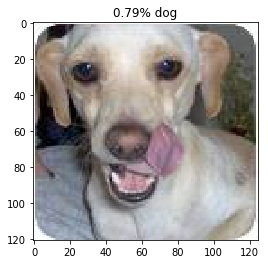

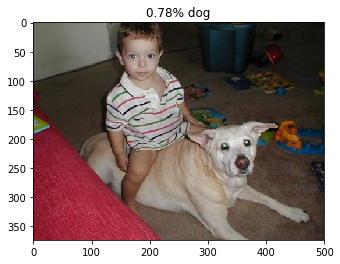

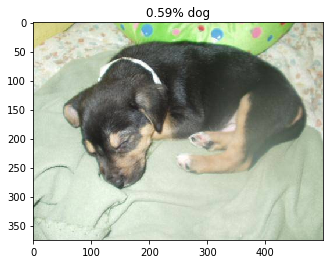

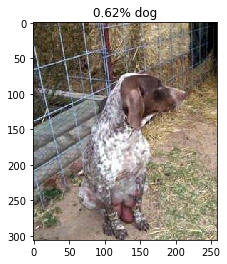

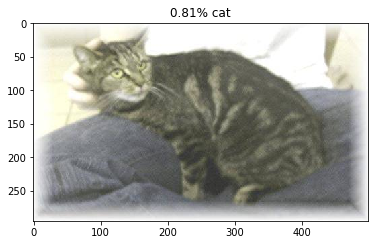

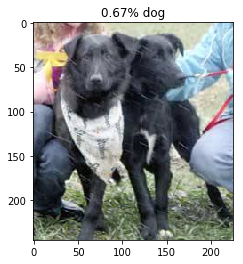

In [48]:
number_of_prediction_to_check = 6

element_offset = 160

for n in range(number_of_prediction_to_check):
    prediction = predictions[n + element_offset]
    
    percentage_of_a_class = prediction[0] if prediction[0] > prediction[1] else prediction[1]
    image_class = 'dog' if prediction[0] > prediction[1] else 'cat'
    
    img = matplotlib_image.imread(test_data_path + '/' + test_data_generator.filenames[n + element_offset])
    
    pyplot.imshow(img)
    pyplot.title('%.2f'  % percentage_of_a_class + '% ' + image_class)
    pyplot.show()

### Model 1

In [49]:
#r, g, b
image_channel_length = 3
number_of_class = 2

input_layer = keras_layers.Input(shape=(image_width, image_height, image_channel_length))

flattened_input = keras_layers.Flatten()(input_layer)

layers = [{'neuron': 1024}, {'dropout': 0.3}, {'neuron': 768}, {'dropout': 0.5}, {'neuron': 368}]

layer_stack = flattened_input

for layer in layers:
    if 'neuron' in layer:
        layer_stack = keras_layers.Dense(
            units=layer['neuron'],
            activation=keras.activations.relu,
            use_bias=True)(layer_stack)
    elif 'dropout' in layer:
        layer_stack = keras_layers.Dropout(rate=layer['dropout'])(layer_stack)

output_layer = keras_layers.Dense(
    units=number_of_class,
    activation=keras.activations.sigmoid,
    use_bias=True)(layer_stack)

In [50]:
learning_rate = 0.01

model = keras_models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras_optimizers.SGD(lr=learning_rate),
    loss=keras_losses.binary_crossentropy,
    metrics=[keras_metrics.Recall(), keras_metrics.Precision()])

In [51]:
keras.utils.plot_model(model, to_file='models/mlp1.png', show_shapes=True)

model_json = model.to_json()

with open('models/mlp1.json', 'w') as json_file:
    json_file.write(model_json)

In [52]:
model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_data_generator.n // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.n // validation_data_generator.batch_size,
    callbacks=[keras.callbacks.TensorBoard(log_dir='graphs/mlp1/', histogram_freq=0, write_graph=True, write_images=True)],
    epochs=60)

Epoch 1/60
1125/1125 [==============================] - 27s 24ms/step - loss: 0.6978 - recall_2: 0.5391 - precision_2: 0.5355 - val_loss: 0.6769 - val_recall_2: 0.5860 - val_precision_2: 0.5762
Epoch 2/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6762 - recall_2: 0.5728 - precision_2: 0.5723 - val_loss: 0.6825 - val_recall_2: 0.5800 - val_precision_2: 0.5706
Epoch 3/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.6660 - recall_2: 0.5883 - precision_2: 0.5919 - val_loss: 0.6482 - val_recall_2: 0.6350 - val_precision_2: 0.6198
Epoch 4/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6586 - recall_2: 0.6011 - precision_2: 0.6026 - val_loss: 0.6451 - val_recall_2: 0.6665 - val_precision_2: 0.6180
Epoch 5/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6525 - recall_2: 0.6166 - precision_2: 0.6139 - val_loss: 0.6602 - val_recall_2: 0.6120 - val_precision_2: 0.5913
Epoch 6/60
1125/1125 [========

Epoch 54/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.4604 - recall_2: 0.7763 - precision_2: 0.7764 - val_loss: 0.7123 - val_recall_2: 0.6310 - val_precision_2: 0.6301
Epoch 55/60
1125/1125 [==============================] - 24s 22ms/step - loss: 0.4588 - recall_2: 0.7763 - precision_2: 0.7772 - val_loss: 0.6502 - val_recall_2: 0.6640 - val_precision_2: 0.6627
Epoch 56/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.4560 - recall_2: 0.7801 - precision_2: 0.7790 - val_loss: 0.6720 - val_recall_2: 0.6440 - val_precision_2: 0.6392
Epoch 57/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.4506 - recall_2: 0.7825 - precision_2: 0.7819 - val_loss: 0.6657 - val_recall_2: 0.6475 - val_precision_2: 0.6443
Epoch 58/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.4434 - recall_2: 0.7865 - precision_2: 0.7858 - val_loss: 0.7171 - val_recall_2: 0.6380 - val_precision_2: 0.6374
Epoch 59/60
1125/1125 [==

In [53]:
model.save('models/mlp1.hdf5')

In [54]:
predictions = model.predict_generator(generator=test_data_generator)

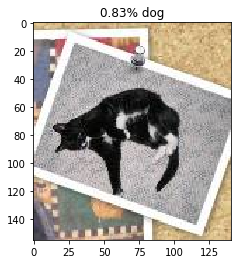

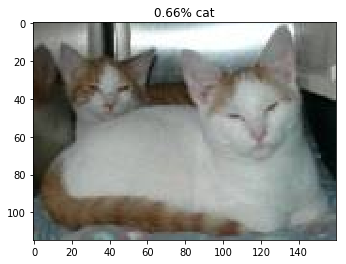

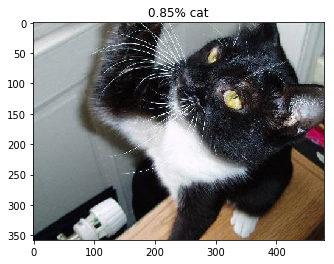

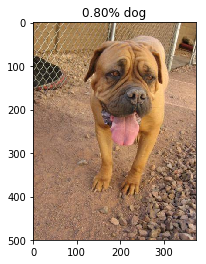

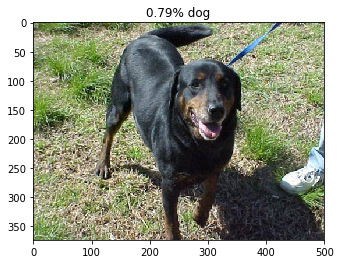

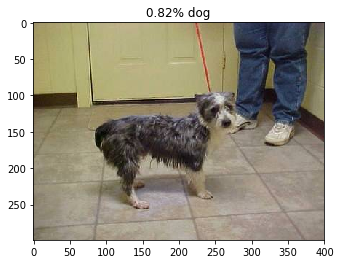

In [57]:
number_of_prediction_to_check = 6

element_offset = 180

for n in range(number_of_prediction_to_check):
    prediction = predictions[n + element_offset]
    
    percentage_of_a_class = prediction[0] if prediction[0] > prediction[1] else prediction[1]
    image_class = 'dog' if prediction[0] > prediction[1] else 'cat'
    
    img = matplotlib_image.imread(test_data_path + '/' + test_data_generator.filenames[n + element_offset])
    
    pyplot.imshow(img)
    pyplot.title('%.2f'  % percentage_of_a_class + '% ' + image_class)
    pyplot.show()

### Model 2

In [58]:
#r, g, b
image_channel_length = 3
number_of_class = 2

input_layer = keras_layers.Input(shape=(image_width, image_height, image_channel_length))

flattened_input = keras_layers.Flatten()(input_layer)

layers = [{'neuron': 768}, {'dropout': 0.3}, {'neuron': 1024}, {'dropout': 0.3}, {'neuron': 1024}, {'dropout': 0.3}, {'neuron': 1024}, {'dropout': 0.5}, {'neuron': 368}]

layer_stack = flattened_input

for layer in layers:
    if 'neuron' in layer:
        layer_stack = keras_layers.Dense(
            units=layer['neuron'],
            activation=keras.activations.relu,
            use_bias=True)(layer_stack)
    elif 'dropout' in layer:
        layer_stack = keras_layers.Dropout(rate=layer['dropout'])(layer_stack)

output_layer = keras_layers.Dense(
    units=number_of_class,
    activation=keras.activations.sigmoid,
    use_bias=True)(layer_stack)

In [59]:
learning_rate = 0.01

model = keras_models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras_optimizers.SGD(lr=learning_rate),
    loss=keras_losses.binary_crossentropy,
    metrics=[keras_metrics.Recall(), keras_metrics.Precision()])

In [60]:
keras.utils.plot_model(model, to_file='models/mlp2.png', show_shapes=True)

model_json = model.to_json()

with open('models/mlp2.json', 'w') as json_file:
    json_file.write(model_json)

In [61]:
model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_data_generator.n // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.n // validation_data_generator.batch_size,
    callbacks=[keras.callbacks.TensorBoard(log_dir='graphs/mlp2/', histogram_freq=0, write_graph=True, write_images=True)],
    epochs=60)

Epoch 1/60
1125/1125 [==============================] - 28s 25ms/step - loss: 0.6986 - recall_3: 0.5165 - precision_3: 0.5159 - val_loss: 0.6846 - val_recall_3: 0.4455 - val_precision_3: 0.5846
Epoch 2/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6873 - recall_3: 0.5419 - precision_3: 0.5452 - val_loss: 0.6716 - val_recall_3: 0.5610 - val_precision_3: 0.5933
Epoch 3/60
1125/1125 [==============================] - 27s 24ms/step - loss: 0.6785 - recall_3: 0.5713 - precision_3: 0.5691 - val_loss: 0.6627 - val_recall_3: 0.5645 - val_precision_3: 0.6159
Epoch 4/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.6692 - recall_3: 0.5913 - precision_3: 0.5881 - val_loss: 0.6610 - val_recall_3: 0.6050 - val_precision_3: 0.6044
Epoch 5/60
1125/1125 [==============================] - 25s 22ms/step - loss: 0.6616 - recall_3: 0.5988 - precision_3: 0.6029 - val_loss: 0.6476 - val_recall_3: 0.6030 - val_precision_3: 0.6317
Epoch 6/60
1125/1125 [========

Epoch 28/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.5765 - recall_3: 0.6901 - precision_3: 0.6899 - val_loss: 0.6321 - val_recall_3: 0.6540 - val_precision_3: 0.6533
Epoch 29/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.5759 - recall_3: 0.6921 - precision_3: 0.6928 - val_loss: 0.6266 - val_recall_3: 0.6335 - val_precision_3: 0.6332
Epoch 30/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.5719 - recall_3: 0.6962 - precision_3: 0.6953 - val_loss: 0.6981 - val_recall_3: 0.5675 - val_precision_3: 0.5667
Epoch 31/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.5674 - recall_3: 0.6985 - precision_3: 0.7004 - val_loss: 0.6200 - val_recall_3: 0.6550 - val_precision_3: 0.6543
Epoch 32/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.5640 - recall_3: 0.7007 - precision_3: 0.7005 - val_loss: 0.6180 - val_recall_3: 0.6585 - val_precision_3: 0.6575
Epoch 33/60
1125/1125 [==

Epoch 55/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.4690 - recall_3: 0.7716 - precision_3: 0.7716 - val_loss: 0.6508 - val_recall_3: 0.6575 - val_precision_3: 0.6582
Epoch 56/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.4632 - recall_3: 0.7739 - precision_3: 0.7742 - val_loss: 0.6256 - val_recall_3: 0.6690 - val_precision_3: 0.6677
Epoch 57/60
1125/1125 [==============================] - 25s 23ms/step - loss: 0.4589 - recall_3: 0.7811 - precision_3: 0.7796 - val_loss: 0.6699 - val_recall_3: 0.6545 - val_precision_3: 0.6555
Epoch 58/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.4541 - recall_3: 0.7816 - precision_3: 0.7818 - val_loss: 0.8136 - val_recall_3: 0.6380 - val_precision_3: 0.6380
Epoch 59/60
1125/1125 [==============================] - 26s 23ms/step - loss: 0.4552 - recall_3: 0.7794 - precision_3: 0.7791 - val_loss: 0.6639 - val_recall_3: 0.6600 - val_precision_3: 0.6617
Epoch 60/60
1125/1125 [==

In [62]:
model.save('models/mlp2.hdf5')

In [63]:
predictions = model.predict_generator(generator=test_data_generator)

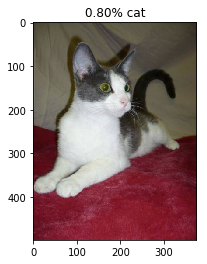

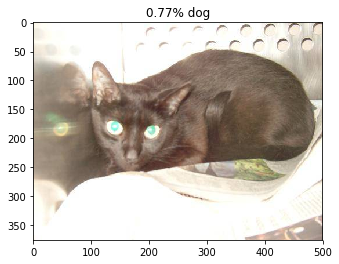

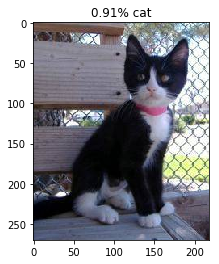

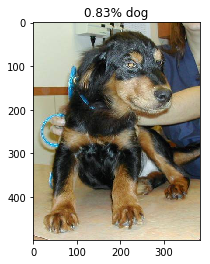

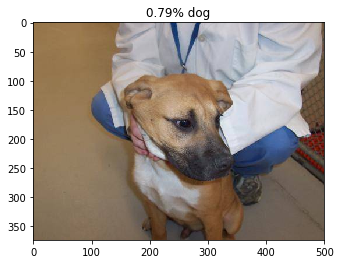

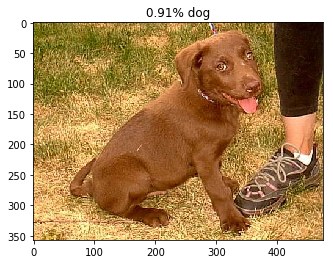

In [67]:
number_of_prediction_to_check = 6

element_offset = 230

for n in range(number_of_prediction_to_check):
    prediction = predictions[n + element_offset]
    
    percentage_of_a_class = prediction[0] if prediction[0] > prediction[1] else prediction[1]
    image_class = 'dog' if prediction[0] > prediction[1] else 'cat'
    
    img = matplotlib_image.imread(test_data_path + '/' + test_data_generator.filenames[n + element_offset])
    
    pyplot.imshow(img)
    pyplot.title('%.2f'  % percentage_of_a_class + '% ' + image_class)
    pyplot.show()

### Model 3 with data augmentation

In [27]:
train_image_generator = keras_preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')
validate_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)
test_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 16

# dog and cat
classes = ['0', '1']

train_data_generator = train_image_generator.flow_from_directory(
    directory=train_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

validation_data_generator = validate_image_generator.flow_from_directory(
    directory=validation_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

test_data_generator = test_image_generator.flow_from_directory(
    target_size=(image_width, image_height),
    directory=test_data_path,
    class_mode='categorical',
    batch_size=1,
    shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [28]:
#r, g, b
image_channel_length = 3
number_of_class = 2

input_layer = keras_layers.Input(shape=(image_width, image_height, image_channel_length))

flattened_input = keras_layers.Flatten()(input_layer)

layers = [{'neuron': 30}, {'dropout': 0.5}, {'neuron': 90}, {'neuron': 30}]

layer_stack = flattened_input

for layer in layers:
    if 'neuron' in layer:
        layer_stack = keras_layers.Dense(
            units=layer['neuron'],
            activation=keras.activations.relu,
            use_bias=True)(layer_stack)
    elif 'dropout' in layer:
        layer_stack = keras_layers.Dropout(rate=layer['dropout'])(layer_stack)

output_layer = keras_layers.Dense(
    units=number_of_class,
    activation=keras.activations.sigmoid,
    use_bias=True)(layer_stack)

In [35]:
learning_rate = 0.0001

model = keras_models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras_optimizers.Adam(learning_rate=learning_rate),
    loss=keras_losses.categorical_crossentropy,
    metrics=[keras_metrics.Recall(), keras_metrics.Precision()])

In [36]:
keras.utils.plot_model(model, to_file='models/mlp3.png', show_shapes=True)

model_json = model.to_json()

with open('models/mlp3.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_data_generator.n // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.n // validation_data_generator.batch_size,
    callbacks=[keras.callbacks.TensorBoard(log_dir='graphs/mlp3/', histogram_freq=0, write_graph=True, write_images=True)],
    epochs=100)

/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
1125/1125 [==============================] - 134s 119ms/step - loss: 0.6920 - recall_7: 0.9941 - precision_7: 0.5008 - val_loss: 0.6911 - val_recall_7: 1.0000 - val_precision_7: 0.5000
Epoch 2/100
1125/1125 [==============================] - 97s 86ms/step - loss: 0.6908 - recall_7: 0.9916 - precision_7: 0.5017 - val_loss: 0.6897 - val_recall_7: 0.9830 - val_precision_7: 0.5055
Epoch 3/100
1125/1125 [==============================] - 104s 93ms/step - loss: 0.6905 - recall_7: 0.9904 - precision_7: 0.5018 - val_loss: 0.6895 - val_recall_7: 0.9985 - val_precision_7: 0.5001
Epoch 4/100
1125/1125 [==============================] - 96s 85ms/step - loss: 0.6902 - recall_7: 0.9918 - precision_7: 0.5022 - val_loss: 0.6886 - val_recall_7: 0.9835 - val_precision_7: 0.5050
Epoch 5/100
1125/1125 [==============================] - 99s 88ms/step - loss: 0.6898 - recall_7: 0.9863 - precision_7: 0.5027 - val_loss: 0.6887 - val_recall_7: 0.9815 - val_precision_7: 0.5063
Epoch 6/100
1125/1125 

### CNN 0

In [7]:
train_image_generator = keras_preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect')
validate_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)
test_image_generator = keras_preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 16

# dog and cat
classes = ['0', '1']

train_data_generator = train_image_generator.flow_from_directory(
    directory=train_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

validation_data_generator = validate_image_generator.flow_from_directory(
    directory=validation_data_path,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    classes=classes,
    class_mode='categorical',
    shuffle=True)

test_data_generator = test_image_generator.flow_from_directory(
    target_size=(image_width, image_height),
    directory=test_data_path,
    class_mode='categorical',
    batch_size=1,
    shuffle=False)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
#r, g, b
image_channel_length = 3
number_of_class = 2

input_layer = keras_layers.Input(shape=(image_width, image_height, image_channel_length))

conv_layer_stack = input_layer

convolutional_blocks = [
    {'filters': 32, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 64, 'kernel_size': 3, 'pool_size': 2},
    {'filters': 128, 'kernel_size': 3, 'pool_size': 2},
]

for blocks in convolutional_blocks:
    conv_layer_stack = keras_layers.Conv2D(
        filters=blocks['filters'],
        kernel_size=blocks['kernel_size'],
        padding='valid',
        activation=keras.activations.relu)(conv_layer_stack)
    
    conv_layer_stack = keras_layers.MaxPooling2D(pool_size=blocks['pool_size'])(conv_layer_stack)

layers = [
    {'neuron': 320},
    {'dropout': 0.5},
    {'neuron': 760},
    {'dropout': 0.5},
    {'neuron': 760},
    {'dropout': 0.5},
    {'neuron': 760},
    {'dropout': 0.5},
    {'neuron': 320}
]

layer_stack = keras_layers.Flatten()(conv_layer_stack)

for layer in layers:
    if 'neuron' in layer:
        layer_stack = keras_layers.Dense(
            units=layer['neuron'],
            activation=keras.activations.relu,
            use_bias=True)(layer_stack)
    elif 'dropout' in layer:
        layer_stack = keras_layers.Dropout(rate=layer['dropout'])(layer_stack)

output_layer = keras_layers.Dense(
    units=number_of_class,
    activation=keras.activations.sigmoid,
    use_bias=True)(layer_stack)

In [5]:
learning_rate = 0.0001

model = keras_models.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras_optimizers.Adam(learning_rate=learning_rate),
    loss=keras_losses.categorical_crossentropy,
    metrics=[keras_metrics.Recall(), keras_metrics.Precision()])

In [75]:
keras.utils.plot_model(model, to_file='models/cnn0.png', show_shapes=True)

model_json = model.to_json()

with open('models/cnn0.json', 'w') as json_file:
    json_file.write(model_json)

In [76]:
model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=train_data_generator.n // train_data_generator.batch_size,
    validation_data=validation_data_generator,
    validation_steps=validation_data_generator.n // validation_data_generator.batch_size,
    callbacks=[
        keras.callbacks.TensorBoard(log_dir='graphs/cnn0/', histogram_freq=0, write_graph=True, write_images=True),
        keras.callbacks.EarlyStopping(patience=10),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=learning_rate, patience=10, factor=0.2)
    ],
    epochs=100)

/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:699: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:707: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
1125/1125 [==============================] - 184s 164ms/step - loss: 0.6921 - recall_12: 0.7744 - precision_12: 0.5051 - val_loss: 0.6827 - val_recall_12: 0.6205 - val_precision_12: 0.5840
Epoch 2/100
1125/1125 [==============================] - 173s 154ms/step - loss: 0.6472 - recall_12: 0.5836 - precision_12: 0.6323 - val_loss: 0.6070 - val_recall_12: 0.6260 - val_precision_12: 0.6583
Epoch 3/100
1125/1125 [==============================] - 202s 180ms/step - loss: 0.5857 - recall_12: 0.6604 - precision_12: 0.7010 - val_loss: 0.5522 - val_recall_12: 0.6945 - val_precision_12: 0.7141
Epoch 4/100
1125/1125 [==============================] - 190s 169ms/step - loss: 0.5561 - recall_12: 0.7051 - precision_12: 0.7271 - val_loss: 0.5325 - val_recall_12: 0.7240 - val_precision_12: 0.7399
Epoch 5/100
1125/1125 [==============================] - 202s 179ms/step - loss: 0.5333 - recall_12: 0.7147 - precision_12: 0.7423 - val_loss: 0.5176 - val_recall_12: 0.7210 - val_precision_12: 0.

Epoch 82/100
1125/1125 [==============================] - 183s 162ms/step - loss: 0.2681 - recall_12: 0.8801 - precision_12: 0.8908 - val_loss: 0.2901 - val_recall_12: 0.8670 - val_precision_12: 0.8775
Epoch 83/100
1125/1125 [==============================] - 191s 170ms/step - loss: 0.2654 - recall_12: 0.8792 - precision_12: 0.8907 - val_loss: 0.3027 - val_recall_12: 0.8690 - val_precision_12: 0.8796
Epoch 84/100
1125/1125 [==============================] - 184s 163ms/step - loss: 0.2679 - recall_12: 0.8792 - precision_12: 0.8900 - val_loss: 0.2869 - val_recall_12: 0.8685 - val_precision_12: 0.8786
Epoch 85/100
1125/1125 [==============================] - 193s 171ms/step - loss: 0.2670 - recall_12: 0.8778 - precision_12: 0.8895 - val_loss: 0.2902 - val_recall_12: 0.8635 - val_precision_12: 0.8816
Epoch 86/100
1125/1125 [==============================] - 180s 160ms/step - loss: 0.2511 - recall_12: 0.8898 - precision_12: 0.8987 - val_loss: 0.2822 - val_recall_12: 0.8720 - val_precision_1

In [77]:
model.save('models/cnn0.hdf5')

In [78]:
predictions = model.predict_generator(generator=test_data_generator)

In [8]:
saved_model = keras_models.load_model('models/cnn0.hdf5')

saved_model_predictions = saved_model.predict_generator(generator=test_data_generator)

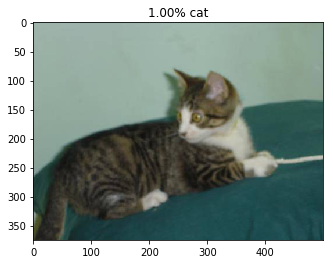

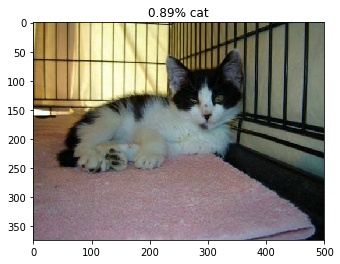

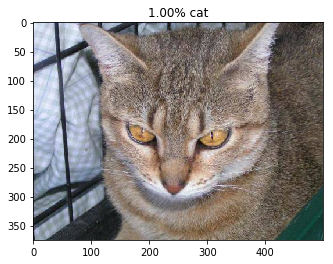

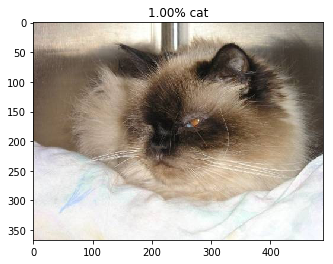

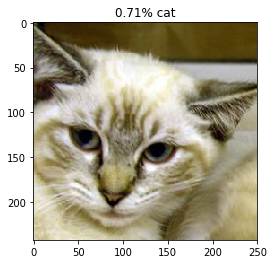

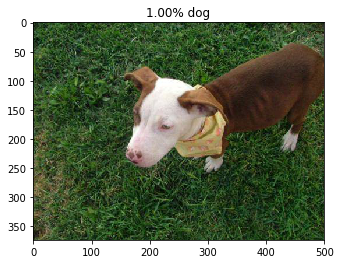

In [10]:
number_of_prediction_to_check = 6

element_offset = 10

for n in range(number_of_prediction_to_check):
    prediction = saved_model_predictions[n + element_offset]
    
    percentage_of_a_class = prediction[0] if prediction[0] > prediction[1] else prediction[1]
    image_class = 'dog' if prediction[0] > prediction[1] else 'cat'
    
    with open(test_data_path + '/' + test_data_generator.filenames[n + element_offset], 'rb') as image_file:
        image = PIL.Image.open(image_file)
    
#     img = matplotlib_image.imread(test_data_path + '/' + test_data_generator.filenames[n + element_offset])
    
        pyplot.imshow(image)
        pyplot.title('%.2f'  % percentage_of_a_class + '% ' + image_class)
        pyplot.show()

In [11]:
saved_model.save_weights('models/cnn0_weights.h5')